In [1]:
!pip -q install timm==0.9.12 scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.0 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os, torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# === 記得修改路徑!!! ===
best_model_path = "/content/drive/MyDrive/DLA_term_project_data/模型/pth檔/DL_Hand_Crafted_chanyiGNN_best_model.pth"
test_dir       = "/content/drive/MyDrive/DLA_term_project_data/new_barry_data"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(*imagenet_stats)
])

test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
test_loader  = DataLoader(test_dataset, batch_size=batch_size,
                          shuffle=False, num_workers=4, pin_memory=True)
num_classes  = len(test_dataset.classes)
print("✔ Test classes:", test_dataset.classes)


✔ Test classes: ['node_1', 'node_10', 'node_11', 'node_12', 'node_13', 'node_14', 'node_15', 'node_16', 'node_17', 'node_18', 'node_19', 'node_2', 'node_20', 'node_21', 'node_22', 'node_3', 'node_4', 'node_5', 'node_6', 'node_7', 'node_8', 'node_9']


In [4]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []

    for imgs, labels in loader:
        imgs  = imgs.to(device, non_blocking=True)
        labels= labels.to(device, non_blocking=True)
        logits= model(imgs)
        preds = torch.argmax(logits, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

    print(f"Accuracy  : {accuracy_score(y_true, y_pred):.4f}")
    print(f"Macro Prec: {precision_score(y_true, y_pred, average='macro'):.4f}"
          f"  Recall: {recall_score(y_true, y_pred, average='macro'):.4f}"
          f"  F1: {f1_score(y_true, y_pred, average='macro'):.4f}")
    print(f"Micro Prec: {precision_score(y_true, y_pred, average='micro'):.4f}"
          f"  Recall: {recall_score(y_true, y_pred, average='micro'):.4f}"
          f"  F1: {f1_score(y_true, y_pred, average='micro'):.4f}")


In [5]:
# ---------- PatchGNNNet 類別定義 ----------
import torch
import torch.nn as nn
import torch.nn.functional as F

class PatchGNNNet(nn.Module):
    def __init__(self, num_classes=22, in_ch=3, stem_channels=64,
                 patch_size=2, hidden_dim=128, gc_hidden=256):
        super().__init__()
        self.patch_size = patch_size

        # 1) CNN Stem 產生 (hidden_dim, 14, 14) 特徵圖
        self.stem = nn.Sequential(
            nn.Conv2d(in_ch, stem_channels, 7, 2, 3, bias=False),
            nn.BatchNorm2d(stem_channels), nn.Mish(),
            nn.MaxPool2d(3, 2, 1),

            nn.Conv2d(stem_channels, stem_channels*2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(stem_channels*2), nn.Mish(),

            nn.Conv2d(stem_channels*2, stem_channels*4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(stem_channels*4), nn.Mish(),

            nn.Conv2d(stem_channels*4, hidden_dim, 3, 1, 1, bias=False),
            nn.BatchNorm2d(hidden_dim), nn.Mish()
        )

        # 2) GraphConv：一次 8-neighbor 信息融合
        self.gc_in  = nn.Linear(hidden_dim, gc_hidden, bias=False)
        self.gc_nei = nn.Linear(hidden_dim, gc_hidden, bias=False)
        self.gc_act = nn.Mish()

        # 3) MLP Head
        self.mlp_head = nn.Sequential(
            nn.Linear(gc_hidden, gc_hidden), nn.Mish(), nn.Dropout(0.3),
            nn.Linear(gc_hidden, num_classes)
        )

    def forward(self, x):
        B = x.size(0)
        f = self.stem(x)                     # (B, C=hidden_dim, 14, 14)

        C, H, W = f.shape[1:]
        p = self.patch_size
        assert H % p == 0 and W % p == 0, "patch_size 必須整除特徵圖大小"

        # 切 patch → (B, N, C)
        f = f.unfold(2, p, p).unfold(3, p, p)          # (B, C, H/p, p, W/p, p)
        f = f.contiguous().view(B, C, H//p, p, W//p, p)
        patch_avg = f.mean(3).mean(4)                  # (B, C, H/p, W/p)
        h, w = H // p, W // p
        N = h * w
        patch_feat = patch_avg.view(B, C, N).permute(0, 2, 1)  # (B, N, C)

        # 8-neighbor 聚合
        grid = patch_feat.view(B, h, w, C)
        pad_grid = F.pad(grid, (0,0,1,1,1,1))          # pad 掉邊界
        nei_sum = torch.zeros_like(grid)
        for dy in (-1,0,1):
            for dx in (-1,0,1):
                if dy == 0 and dx == 0: continue
                nei_sum += pad_grid[:, 1+dy:1+dy+h, 1+dx:1+dx+w, :]
        nei_mean = nei_sum / 8.0                       # (B, h, w, C)

        self_feat = self.gc_in(patch_feat)             # (B, N, gc_hidden)
        nei_feat  = self.gc_nei(nei_mean.view(B, N, C))
        gconv     = self.gc_act(self_feat + nei_feat)  # (B, N, gc_hidden)

        graph_feat = gconv.mean(1)                     # global avg → (B, gc_hidden)
        return self.mlp_head(graph_feat)

# ----------  建模型 / 載權重  ----------
model = PatchGNNNet(
    num_classes=num_classes,   # ← test_dataset.classes 的數量
    in_ch=3,
    stem_channels=64,
    patch_size=2,              # 與訓練時一致
    hidden_dim=128,
    gc_hidden=256
).to(device)

state = torch.load(best_model_path, map_location=device)
model.load_state_dict(state)
print("✔ Weights loaded")

# ----------  評估  ----------
evaluate(model, test_loader)



✔ Weights loaded
Accuracy  : 0.2883
Macro Prec: 0.2037  Recall: 0.3212  F1: 0.2131
Micro Prec: 0.2883  Recall: 0.2883  F1: 0.2883


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


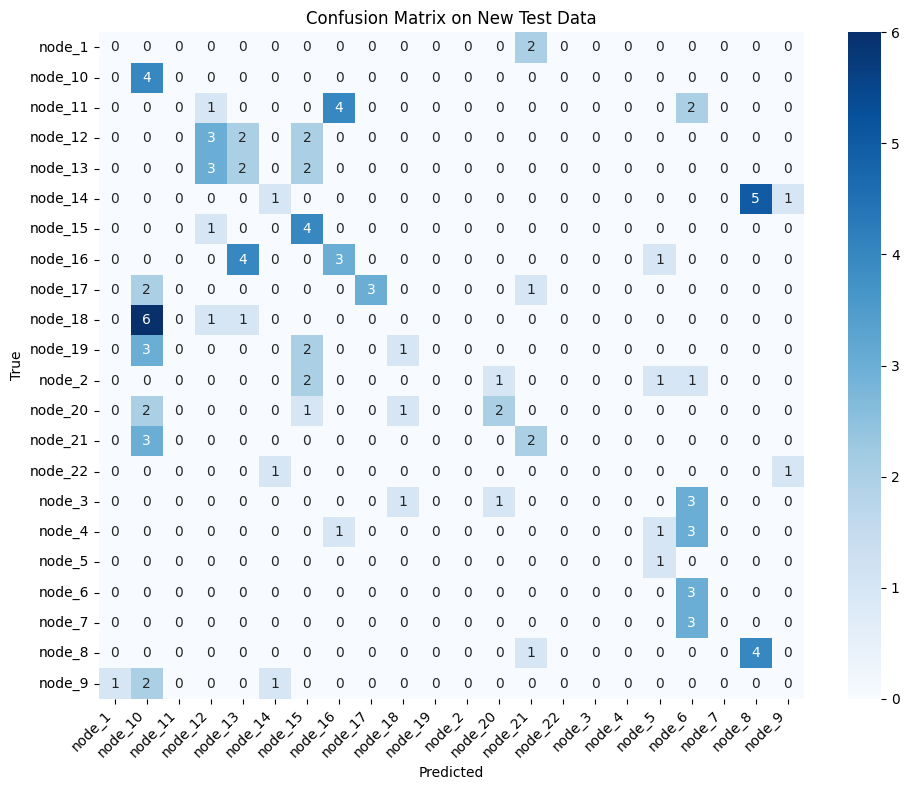

❌ 真實存在但一次也沒被模型預測出的 node(s): []
⚠ 模型從未把任何圖預測成該 node 的 node(s): ['node_11', 'node_19', 'node_2', 'node_22', 'node_3', 'node_4', 'node_7']


In [6]:
# --- 重新收集 all_labels & all_preds 並畫混淆矩陣 ---
import torch
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 重新跑推論，把所有 ground-truth labels / predictions 收集起來
model.eval()
all_labels, all_preds = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# 2. 取得類別數量與名稱
num_classes = len(test_dataset.classes)
class_names = test_dataset.classes

# 3. 計算混淆矩陣
cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

# 4. 畫 heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix on New Test Data")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 5. 列出被忽略的節點
missed_true_nodes = [class_names[i] for i, row in enumerate(cm) if row.sum() == 0]
never_predicted_nodes = [class_names[i] for i, col in enumerate(cm.T) if col.sum() == 0]

print("❌ 真實存在但一次也沒被模型預測出的 node(s):", missed_true_nodes)
print("⚠ 模型從未把任何圖預測成該 node 的 node(s):", never_predicted_nodes)

